# VAR Model

## Packages and Dataset

In [160]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen

from datetime import timedelta

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_percentage_error

In [161]:
df = pd.read_csv("../Data/KRS_cleaned_linear_interpolation.csv", index_col=['FLOW_DATE'], parse_dates=['FLOW_DATE'])
df = df.fillna(method='ffill')
df['MONTH_NO'] = df.index.month

In [162]:
df

,SL_NO,RESERVOIR,YEAR,WEEK_NO,PRESENT_STORAGE_TMC,RES_LEVEL_FT,INFLOW_CUSECS,OUTFLOW_CUECS,UNIQUE_KEY,MONTH_NO
FLOW_DATE,,,,,,,,,,
2011-01-01,51.0,K.R.S,2011.0,1.0,46.42,122.59,2029.0,2000.0,K.R.S-2011-01-01,1
2011-01-02,52.0,K.R.S,2011.0,1.0,46.54,122.68,3084.0,1490.0,K.R.S-2011-01-02,1
2011-01-03,53.0,K.R.S,2011.0,1.0,46.64,122.75,2776.0,1491.0,K.R.S-2011-01-03,1
2011-01-04,54.0,K.R.S,2011.0,1.0,46.69,122.79,2311.0,1491.0,K.R.S-2011-01-04,1
2011-01-05,55.0,K.R.S,2011.0,1.0,46.70,122.80,1847.0,1491.0,K.R.S-2011-01-05,1
...,...,...,...,...,...,...,...,...,...,...
2020-12-12,43915.0,K.R.S,2020.0,50.0,43.04,120.00,3496.0,3308.0,K.R.S-2020-12-12,12
2020-12-13,43916.0,K.R.S,2020.0,50.0,43.02,119.98,3197.0,3300.0,K.R.S-2020-12-13,12
2020-12-14,43917.0,K.R.S,2020.0,50.0,42.98,119.95,3026.0,3273.0,K.R.S-2020-12-14,12


In [163]:
dataset = df[['RES_LEVEL_FT', 'INFLOW_CUSECS', 'OUTFLOW_CUECS', 'WEEK_NO', 'MONTH_NO']].reset_index()
dataset.head(5)

,FLOW_DATE,RES_LEVEL_FT,INFLOW_CUSECS,OUTFLOW_CUECS,WEEK_NO,MONTH_NO
0,2011-01-01,122.59,2029.0,2000.0,1.0,1
1,2011-01-02,122.68,3084.0,1490.0,1.0,1
2,2011-01-03,122.75,2776.0,1491.0,1.0,1
3,2011-01-04,122.79,2311.0,1491.0,1.0,1
4,2011-01-05,122.80,1847.0,1491.0,1.0,1


## Visualization

<AxesSubplot:xlabel='FLOW_DATE'>

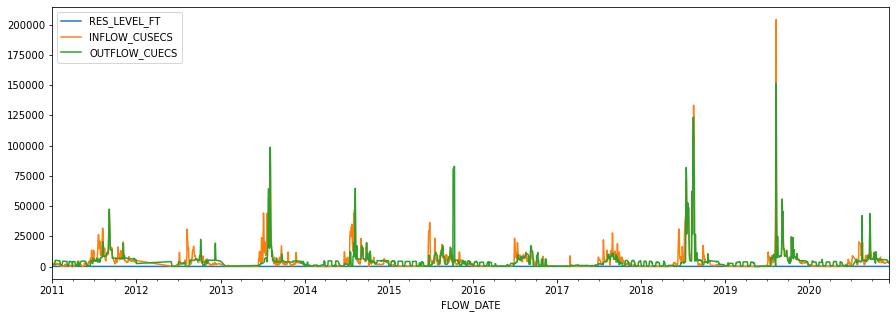

In [164]:
fig, ax = plt.subplots(figsize=(15, 5))
df[['RES_LEVEL_FT', 'INFLOW_CUSECS', 'OUTFLOW_CUECS']].plot(ax=ax)

## Modeling

In [165]:
def generate_dataset(dataset,
                     time_col,
                     train_start,
                     test_start,
                     test_end,
                     internal_regressors,
                     external_regressors=None):
    data_copy = dataset.copy()
    if external_regressors is None:
        data_copy = data_copy.set_index(time_col).drop(columns=[column \
                                                                for column in dataset.columns \
                                                                if column not in internal_regressors + [time_col]])
    else:
        data_copy = data_copy.set_index(time_col).drop(columns=[column \
                                                                for column in dataset.columns \
                                                                if column not in internal_regressors + [time_col] + external_regressors])
    return data_copy

def split_dataset(dataset, 
                  time_col, 
                  train_start,
                  test_start,
                  test_end,
                  internal_regressors, 
                  external_regressors=None):
    
    data_copy = generate_dataset(dataset, 
                                 time_col, 
                                 train_start,
                                 test_start,
                                 test_end,
                                 internal_regressors, 
                                 external_regressors)
    
    data_copy = data_copy[data_copy.index >= train_start]
    
    data_train = data_copy[data_copy.index < test_start]
    data_test = data_copy[data_copy.index >= test_start]
    data_test = data_test[data_test.index <= test_end]
    
    if external_regressors is None:
        endo_train = data_train
        exo_train = None
        endo_test = data_test
        exo_test = None
    else:
        endo_train, exo_train = data_train[internal_regressors], data_train[external_regressors]
        endo_test, exo_test = data_test[internal_regressors], data_test[external_regressors]
    
    return endo_train, exo_train, endo_test, exo_test

def fit_model(endo_train, exo_train=None, maxlag=10, selection_type='bic'):
    model = VAR(endo_train, exog=exo_train, freq='D')
    
    lag_selection = model.select_order(maxlags=maxlag)
    optimal_lag = lag_selection.selected_orders[selection_type]
    
    model_fitted = model.fit(optimal_lag)
    
    return model_fitted, lag_selection, optimal_lag

def forecast_model(model, endo_train, endo_test, exo_test=None, optimal_lag=None, forecast_horizon=90):
    forecast_input = endo_train.values[-optimal_lag:]
    forecast_df = pd.DataFrame(model.forecast(y=forecast_input, 
                                              steps=forecast_horizon,
                                              exog_future=exo_test), 
                               columns=endo_train.columns,
                               index=endo_test.index)
    
    return(forecast_df)

def evaluate_fit(forecast_df, endo_test, evaluation_metric):
    evaluation_results = {}
    for column in forecast_df.columns:
        evaluation_results[column] = [evaluation_metric(y_true=endo_test[column], y_pred=forecast_df[column])]
    return pd.DataFrame(evaluation_results)

def cross_validate(dataset,
                   time_col,
                   internal_regressors,
                   initial,
                   steps,
                   horizon,
                   external_regressors=None,
                   scoring_function=mean_absolute_percentage_error,
                   max_lag=50,
                   selection_type='aic',
                   diff_seed=None):
    
    final_df = pd.DataFrame()
    
    for i in range(initial, dataset.shape[0], steps):
        train_start = pd.to_datetime(dataset[time_col].min()).date()
        test_start = train_start + timedelta(i)
        test_end = test_start + timedelta(horizon-1)
        
        endo_train, exo_train, endo_test, exo_test = split_dataset(dataset,
                                                                   time_col,
                                                                   str(train_start),
                                                                   str(test_start),
                                                                   str(test_end),
                                                                   internal_regressors,
                                                                   external_regressors)
        
        var_model, lag_selection, optimal_lag = fit_model(endo_train, 
                                                          exo_train, 
                                                          maxlag=max_lag, 
                                                          selection_type=selection_type)
        
        forecast_df = forecast_model(var_model, 
                                     endo_train, 
                                     endo_test, 
                                     exo_test, 
                                     optimal_lag, 
                                     forecast_horizon=min(horizon, endo_test.shape[0]))
        
        if diff_seed is not None:
            endo_train.iloc[0, 0] = endo_train.iloc[0, 0] + diff_seed
            endo_train['RES_LEVEL_FT'] = endo_train['RES_LEVEL_FT'].cumsum()
            
            endo_test.iloc[0, 0] = endo_test.iloc[0, 0] + endo_train.iloc[-1, 0]
            endo_test['RES_LEVEL_FT'] = endo_test['RES_LEVEL_FT'].cumsum()
            
            forecast_df.iloc[0, 0] = forecast_df.iloc[0, 0] + endo_train.iloc[-1, 0]
            forecast_df['RES_LEVEL_FT'] = forecast_df['RES_LEVEL_FT'].cumsum()
        
        evaluation_df = evaluate_fit(forecast_df, endo_test, scoring_function)
        
        evaluation_df['TrainStart'] = train_start
        evaluation_df['TestStart'] = test_start
        evaluation_df['TestEnd'] = test_end
        
        if final_df.shape[0] == 0:
            final_df = evaluation_df
        else:
            final_df = pd.concat([final_df, evaluation_df], axis=0)
            
    final_df.index = range(final_df.shape[0])
    return final_df

def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue']
    
    print(p_value)

    if p_value <= signif:
        return 'Stationary'
    else:
        return 'Non-Stationary'

### Model 1

Endogenous Variables:
* 'RES_LEVEL_FT'
* 'INFLOW_CUSECS'

Optimization:
* AIC

In [166]:
time_col = 'FLOW_DATE'
internal_regressors = ['RES_LEVEL_FT', 'INFLOW_CUSECS']
external_regressors = None
initial = 3000
steps = 50
horizon = 90
selection_type = 'aic'
max_lag = 50

In [167]:
cv_results = cross_validate(dataset,
               time_col,
               internal_regressors,
               initial,
               steps,
               horizon,
               external_regressors,
               scoring_function=mean_absolute_percentage_error,
               max_lag=50,
               selection_type=selection_type)

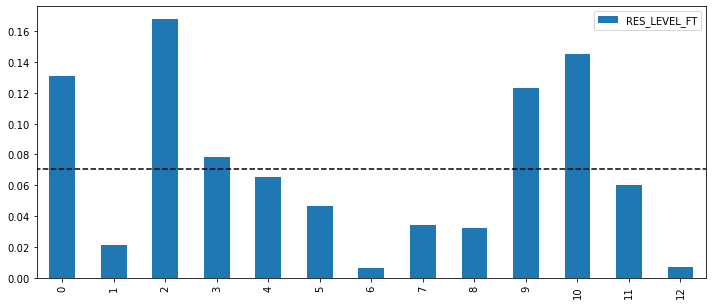

In [168]:
fig, ax = plt.subplots(figsize=(12, 5))
cv_results[['RES_LEVEL_FT']].plot.bar(ax=ax)
average_error = cv_results['RES_LEVEL_FT'].mean()
ax.plot([-1, cv_results.shape[0]], [average_error, average_error], "k--")

In [169]:
endo_train, exo_train, endo_test, exo_test = split_dataset(dataset, 
              time_col, 
              '2011-01-01',
              '2020-09-18',
              '2020-12-16',
              internal_regressors, 
              external_regressors=external_regressors)

model_fitted, lag_selection, optimal_lag = fit_model(endo_train, exo_train=exo_train, maxlag=max_lag, selection_type=selection_type)

forecast_df = forecast_model(model_fitted, endo_train, endo_test, exo_test=exo_test, optimal_lag=optimal_lag, forecast_horizon=horizon)

print(evaluate_fit(forecast_df, endo_test, mean_absolute_percentage_error))

   RES_LEVEL_FT  INFLOW_CUSECS
0       0.06025       0.586426


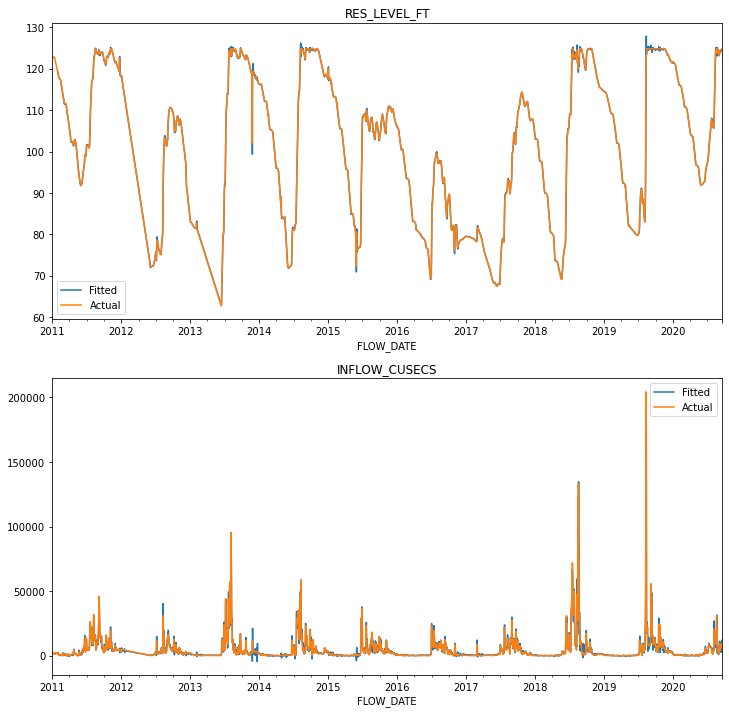

In [170]:
fig, ax = plt.subplots(nrows=endo_train.shape[1], ncols=1, figsize=(12, 12))

for i, column in enumerate(endo_train.columns):
    model_fitted.fittedvalues[column].plot(ax=ax[i], label='Fitted', title=column)
    endo_train[column].plot(ax=ax[i], label='Actual', title=column)
    ax[i].legend()

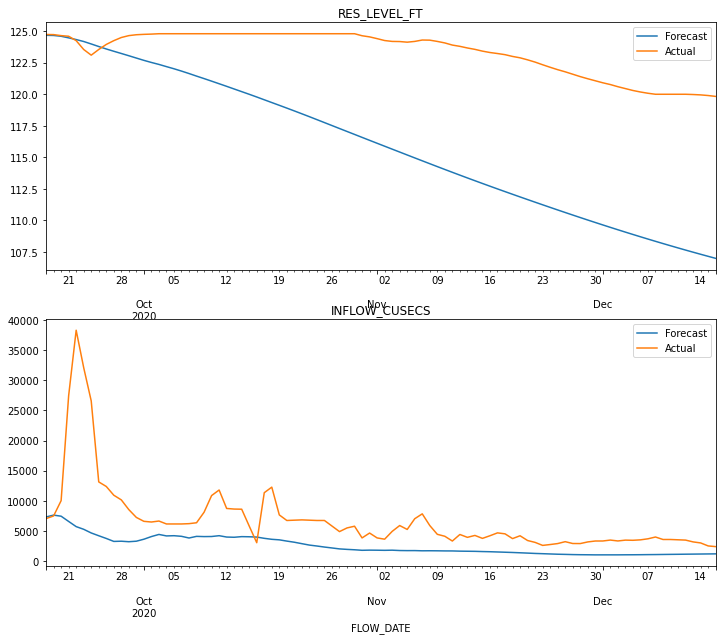

In [171]:
fig, ax = plt.subplots(nrows=forecast_df.shape[1], ncols=1, figsize=(12, 10))

for i, column in enumerate(forecast_df.columns):
    forecast_df[column].plot(ax=ax[i], label='Forecast', title=column)
    endo_test[column].plot(ax=ax[i], label='Actual', title=column)
    ax[i].legend()

### Model 2

Endogenous Variables:
* 'RES_LEVEL_FT'
* 'INFLOW_CUSECS'

Optimization:
* BIC

In [172]:
time_col = 'FLOW_DATE'
internal_regressors = ['RES_LEVEL_FT', 'INFLOW_CUSECS']
external_regressors = None
initial = 3000
steps = 50
horizon = 90
selection_type = 'bic'
max_lag = 50

In [173]:
cv_results = cross_validate(dataset,
               time_col,
               internal_regressors,
               initial,
               steps,
               horizon,
               external_regressors,
               scoring_function=mean_absolute_percentage_error,
               max_lag=50,
               selection_type=selection_type)

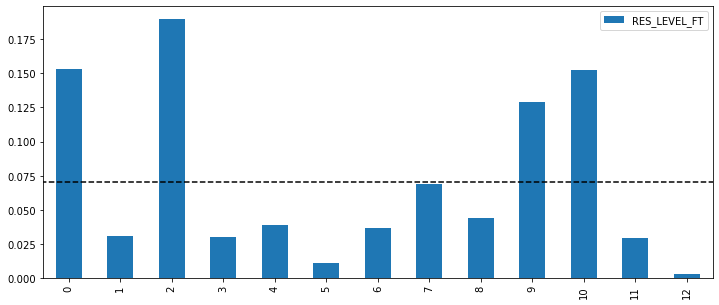

In [174]:
fig, ax = plt.subplots(figsize=(12, 5))
cv_results[['RES_LEVEL_FT']].plot.bar(ax=ax)
average_error = cv_results['RES_LEVEL_FT'].mean()
ax.plot([-1, cv_results.shape[0]], [average_error, average_error], "k--")

In [175]:
endo_train, exo_train, endo_test, exo_test = split_dataset(dataset, 
              time_col, 
              '2011-01-01',
              '2020-09-18',
              '2020-12-16',
              internal_regressors, 
              external_regressors=external_regressors)

model_fitted, lag_selection, optimal_lag = fit_model(endo_train, exo_train=exo_train, maxlag=max_lag, selection_type=selection_type)

forecast_df = forecast_model(model_fitted, endo_train, endo_test, exo_test=exo_test, optimal_lag=optimal_lag, forecast_horizon=horizon)

print(evaluate_fit(forecast_df, endo_test, mean_absolute_percentage_error))

   RES_LEVEL_FT  INFLOW_CUSECS
0      0.030886       0.427879


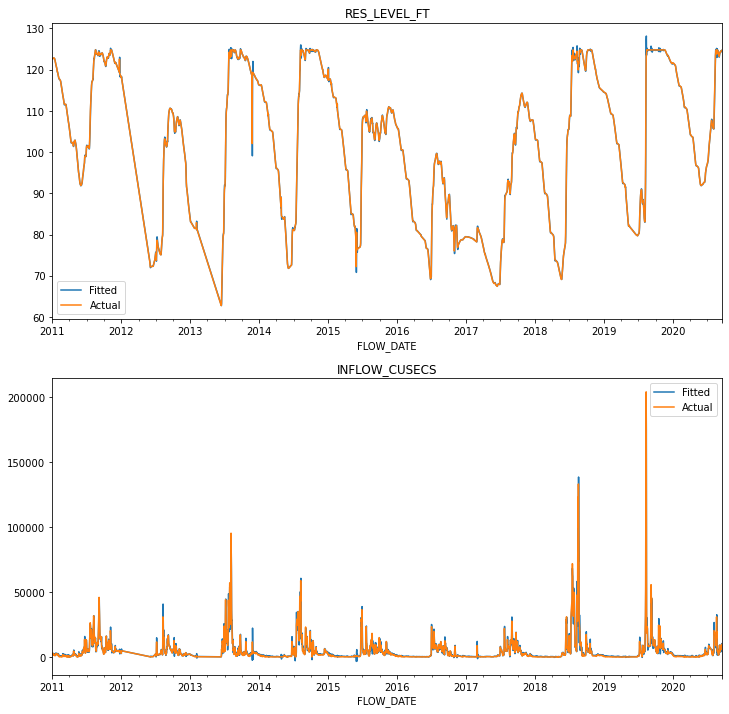

In [176]:
fig, ax = plt.subplots(nrows=endo_train.shape[1], ncols=1, figsize=(12, 12))

for i, column in enumerate(endo_train.columns):
    model_fitted.fittedvalues[column].plot(ax=ax[i], label='Fitted', title=column)
    endo_train[column].plot(ax=ax[i], label='Actual', title=column)
    ax[i].legend()

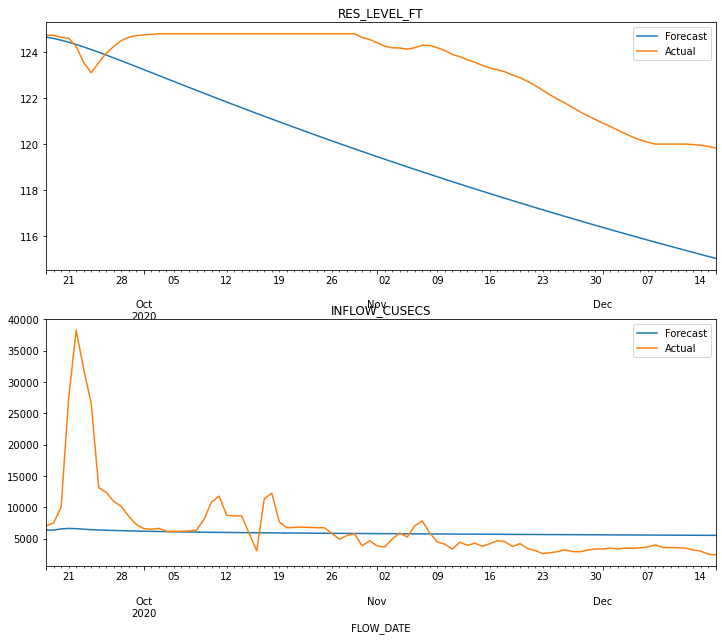

In [177]:
fig, ax = plt.subplots(nrows=forecast_df.shape[1], ncols=1, figsize=(12, 10))

for i, column in enumerate(forecast_df.columns):
    forecast_df[column].plot(ax=ax[i], label='Forecast', title=column)
    endo_test[column].plot(ax=ax[i], label='Actual', title=column)
    ax[i].legend()

### Model 3

Endogenous Variables:
* 'RES_LEVEL_FT'
* 'OUTFLOW_CUECS'

Optimization:
* AIC

In [178]:
time_col = 'FLOW_DATE'
internal_regressors = ['RES_LEVEL_FT', 'OUTFLOW_CUECS']
external_regressors = None
initial = 3000
steps = 50
horizon = 90
selection_type = 'aic'
max_lag = 50

In [179]:
cv_results = cross_validate(dataset,
               time_col,
               internal_regressors,
               initial,
               steps,
               horizon,
               external_regressors,
               scoring_function=mean_absolute_percentage_error,
               max_lag=50,
               selection_type=selection_type)

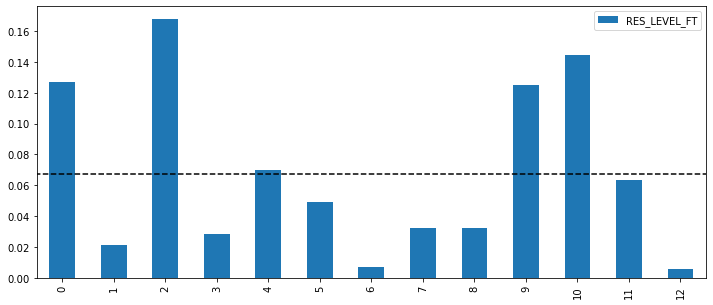

In [180]:
fig, ax = plt.subplots(figsize=(12, 5))
cv_results[['RES_LEVEL_FT']].plot.bar(ax=ax)
average_error = cv_results['RES_LEVEL_FT'].mean()
ax.plot([-1, cv_results.shape[0]], [average_error, average_error], "k--")

In [181]:
endo_train, exo_train, endo_test, exo_test = split_dataset(dataset, 
              time_col, 
              '2011-01-01',
              '2020-09-18',
              '2020-12-16',
              internal_regressors, 
              external_regressors=external_regressors)

model_fitted, lag_selection, optimal_lag = fit_model(endo_train, exo_train=exo_train, maxlag=max_lag, selection_type=selection_type)

forecast_df = forecast_model(model_fitted, endo_train, endo_test, exo_test=exo_test, optimal_lag=optimal_lag, forecast_horizon=horizon)

print(evaluate_fit(forecast_df, endo_test, mean_absolute_percentage_error))

   RES_LEVEL_FT  OUTFLOW_CUECS
0      0.061106       0.324904


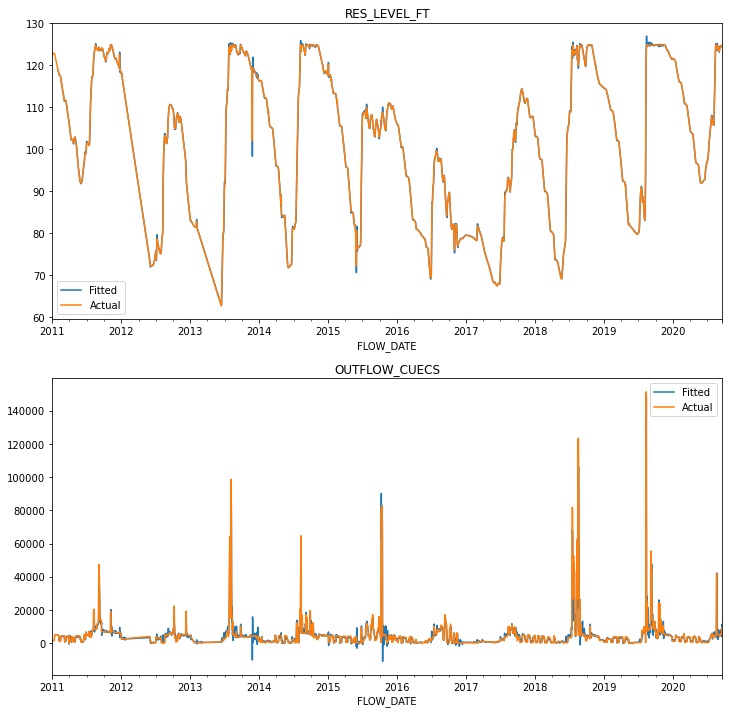

In [182]:
fig, ax = plt.subplots(nrows=endo_train.shape[1], ncols=1, figsize=(12, 12))

for i, column in enumerate(endo_train.columns):
    model_fitted.fittedvalues[column].plot(ax=ax[i], label='Fitted', title=column)
    endo_train[column].plot(ax=ax[i], label='Actual', title=column)
    ax[i].legend()

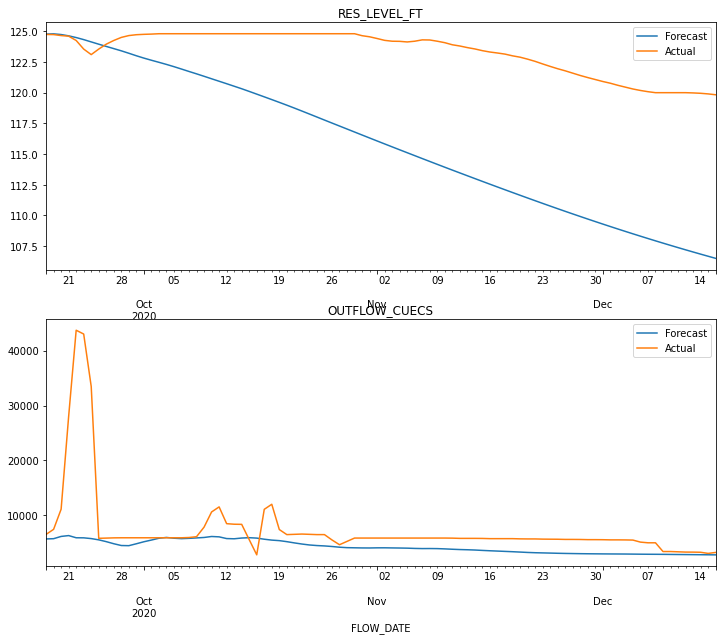

In [183]:
fig, ax = plt.subplots(nrows=forecast_df.shape[1], ncols=1, figsize=(12, 10))

for i, column in enumerate(forecast_df.columns):
    forecast_df[column].plot(ax=ax[i], label='Forecast', title=column)
    endo_test[column].plot(ax=ax[i], label='Actual', title=column)
    ax[i].legend()

### Model 4

Endogenous Variables:
* 'RES_LEVEL_FT'
* 'OUTFLOW_CUECS'

Optimization:
* BIC

In [184]:
time_col = 'FLOW_DATE'
internal_regressors = ['RES_LEVEL_FT', 'OUTFLOW_CUECS']
external_regressors = None
initial = 3000
steps = 50
horizon = 90
selection_type = 'bic'
max_lag = 50

In [185]:
cv_results = cross_validate(dataset,
               time_col,
               internal_regressors,
               initial,
               steps,
               horizon,
               external_regressors,
               scoring_function=mean_absolute_percentage_error,
               max_lag=50,
               selection_type=selection_type)

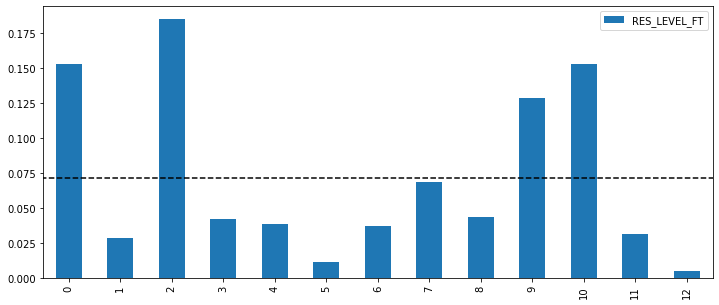

In [186]:
fig, ax = plt.subplots(figsize=(12, 5))
cv_results[['RES_LEVEL_FT']].plot.bar(ax=ax)
average_error = cv_results['RES_LEVEL_FT'].mean()
ax.plot([-1, cv_results.shape[0]], [average_error, average_error], "k--")

In [187]:
endo_train, exo_train, endo_test, exo_test = split_dataset(dataset, 
              time_col, 
              '2011-01-01',
              '2020-09-18',
              '2020-12-16',
              internal_regressors, 
              external_regressors=external_regressors)

model_fitted, lag_selection, optimal_lag = fit_model(endo_train, exo_train=exo_train, maxlag=max_lag, selection_type=selection_type)

forecast_df = forecast_model(model_fitted, endo_train, endo_test, exo_test=exo_test, optimal_lag=optimal_lag, forecast_horizon=horizon)

print(evaluate_fit(forecast_df, endo_test, mean_absolute_percentage_error))

   RES_LEVEL_FT  OUTFLOW_CUECS
0      0.030926         0.2946


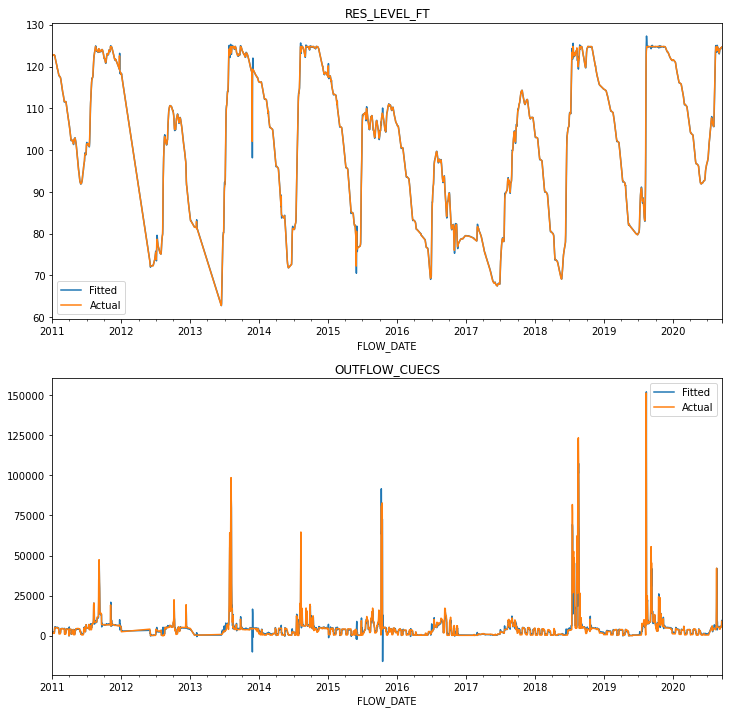

In [188]:
fig, ax = plt.subplots(nrows=endo_train.shape[1], ncols=1, figsize=(12, 12))

for i, column in enumerate(endo_train.columns):
    model_fitted.fittedvalues[column].plot(ax=ax[i], label='Fitted', title=column)
    endo_train[column].plot(ax=ax[i], label='Actual', title=column)
    ax[i].legend()

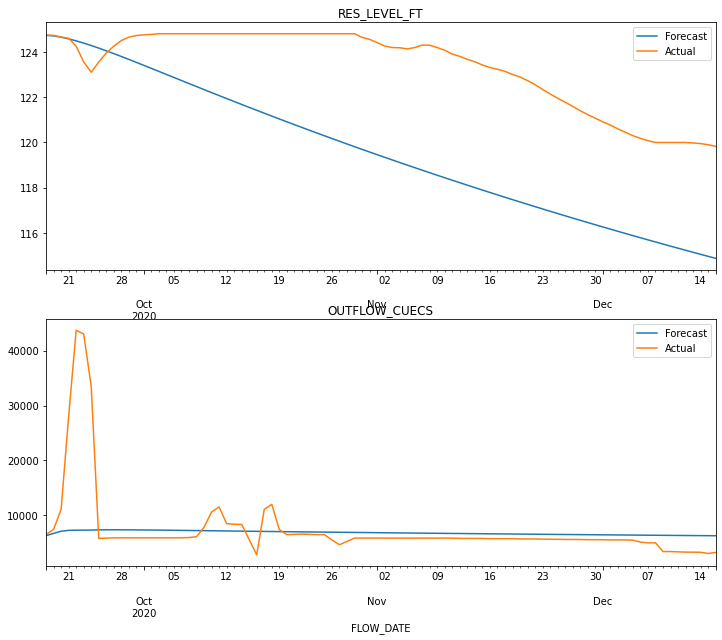

In [189]:
fig, ax = plt.subplots(nrows=forecast_df.shape[1], ncols=1, figsize=(12, 10))

for i, column in enumerate(forecast_df.columns):
    forecast_df[column].plot(ax=ax[i], label='Forecast', title=column)
    endo_test[column].plot(ax=ax[i], label='Actual', title=column)
    ax[i].legend()

### Model 5

Endogenous Variables:
* 'RES_LEVEL_FT'
* 'INFLOW_CUSECS'

Exogenous Variables

* WEEK_NO
* MONTH_NO

Optimization:
* AIC

In [190]:
dummy_data = dataset.copy()
dummy_data['WEEK_NO'] = dummy_data['WEEK_NO'].astype(int).astype(str)
dummy_data['MONTH_NO'] = dummy_data['MONTH_NO'].astype(int).astype(str)
dummy_data = pd.get_dummies(dummy_data)

In [191]:
time_col = 'FLOW_DATE'
internal_regressors = ['RES_LEVEL_FT', 'INFLOW_CUSECS']
initial = 3000
steps = 50
horizon = 90
selection_type = 'aic'
max_lag = 50

In [192]:
external_regressors = [column for column in dummy_data.columns if column not in ['FLOW_DATE', 'INFLOW_CUSECS', 'OUTFLOW_CUECS', 'RES_LEVEL_FT']]

In [193]:
cv_results = cross_validate(dummy_data,
               time_col,
               internal_regressors,
               initial,
               steps,
               horizon,
               external_regressors,
               scoring_function=mean_absolute_percentage_error,
               max_lag=50,
               selection_type=selection_type)

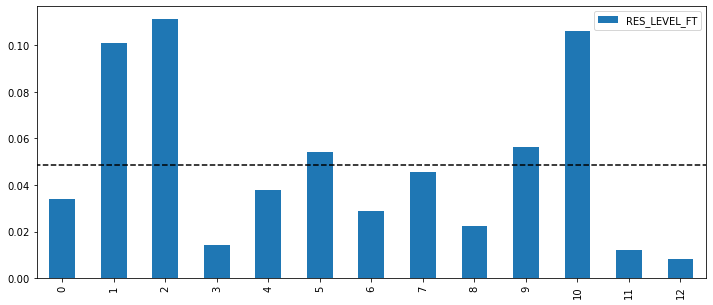

In [194]:
fig, ax = plt.subplots(figsize=(12, 5))
cv_results[['RES_LEVEL_FT']].plot.bar(ax=ax)
average_error = cv_results['RES_LEVEL_FT'].mean()
ax.plot([-1, cv_results.shape[0]], [average_error, average_error], "k--")

In [195]:
endo_train, exo_train, endo_test, exo_test = split_dataset(dummy_data, 
              time_col, 
              '2011-01-01',
              '2020-09-18',
              '2020-12-16',
              internal_regressors, 
              external_regressors=external_regressors)

model_fitted, lag_selection, optimal_lag = fit_model(endo_train, exo_train=exo_train, maxlag=max_lag, selection_type=selection_type)

forecast_df = forecast_model(model_fitted, endo_train, endo_test, exo_test=exo_test, optimal_lag=optimal_lag, forecast_horizon=horizon)

print(evaluate_fit(forecast_df, endo_test, mean_absolute_percentage_error))

   RES_LEVEL_FT  INFLOW_CUSECS
0      0.010812       0.336582


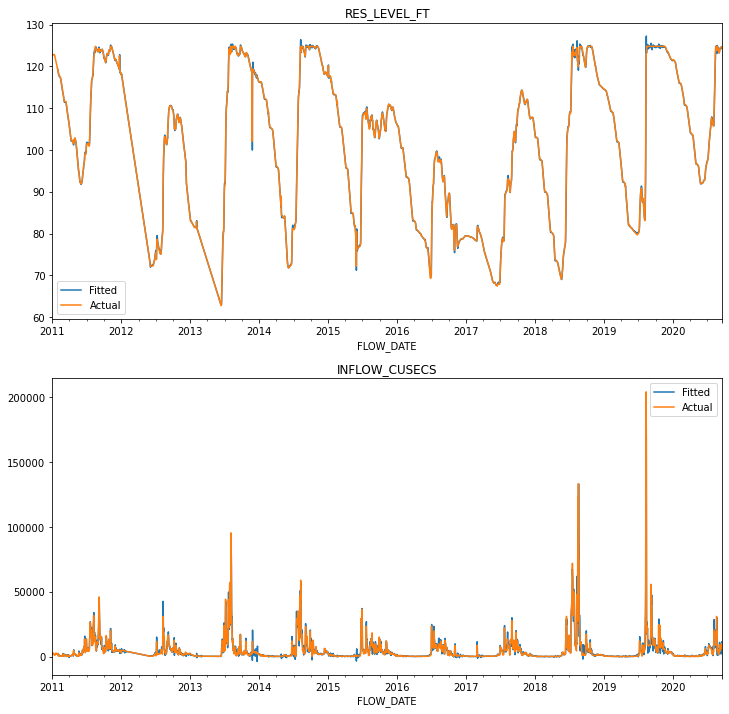

In [196]:
fig, ax = plt.subplots(nrows=endo_train.shape[1], ncols=1, figsize=(12, 12))

for i, column in enumerate(endo_train.columns):
    model_fitted.fittedvalues[column].plot(ax=ax[i], label='Fitted', title=column)
    endo_train[column].plot(ax=ax[i], label='Actual', title=column)
    ax[i].legend()

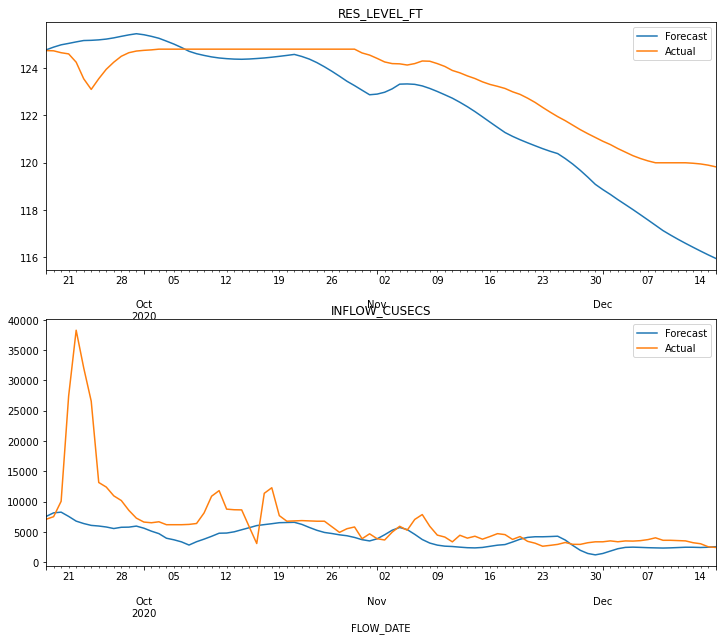

In [197]:
fig, ax = plt.subplots(nrows=forecast_df.shape[1], ncols=1, figsize=(12, 10))

for i, column in enumerate(forecast_df.columns):
    forecast_df[column].plot(ax=ax[i], label='Forecast', title=column)
    endo_test[column].plot(ax=ax[i], label='Actual', title=column)
    ax[i].legend()

### Model 6

Endogenous Variables:
* 'RES_LEVEL_FT'
* 'INFLOW_CUSECS'

Exogenous Variables:
* WEEK_NO
* MONTH_NO

Optimization:
* BIC

In [198]:
dummy_data = dataset.copy()
dummy_data['WEEK_NO'] = dummy_data['WEEK_NO'].astype(int).astype(str)
dummy_data['MONTH_NO'] = dummy_data['MONTH_NO'].astype(int).astype(str)
dummy_data = pd.get_dummies(dummy_data)

In [199]:
time_col = 'FLOW_DATE'
internal_regressors = ['RES_LEVEL_FT', 'INFLOW_CUSECS']
initial = 3000
steps = 50
horizon = 90
selection_type = 'bic'
max_lag = 50

In [200]:
external_regressors = [column for column in dummy_data.columns if column not in ['FLOW_DATE', 'INFLOW_CUSECS', 'OUTFLOW_CUECS', 'RES_LEVEL_FT']]

In [201]:
cv_results = cross_validate(dummy_data,
               time_col,
               internal_regressors,
               initial,
               steps,
               horizon,
               external_regressors,
               scoring_function=mean_absolute_percentage_error,
               max_lag=50,
               selection_type=selection_type)

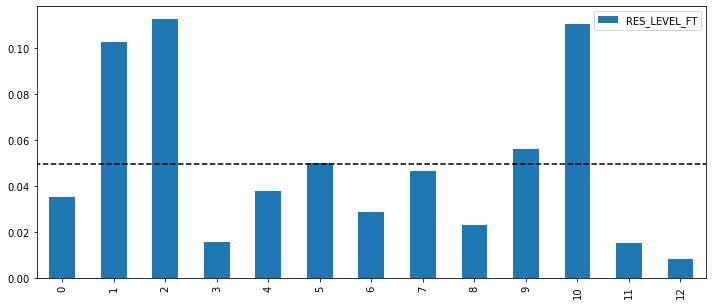

In [202]:
fig, ax = plt.subplots(figsize=(12, 5))
cv_results[['RES_LEVEL_FT']].plot.bar(ax=ax)
average_error = cv_results['RES_LEVEL_FT'].mean()
ax.plot([-1, cv_results.shape[0]], [average_error, average_error], "k--")

In [203]:
endo_train, exo_train, endo_test, exo_test = split_dataset(dummy_data, 
              time_col, 
              '2011-01-01',
              '2020-09-18',
              '2020-12-16',
              internal_regressors, 
              external_regressors=external_regressors)

model_fitted, lag_selection, optimal_lag = fit_model(endo_train, exo_train=exo_train, maxlag=max_lag, selection_type=selection_type)

forecast_df = forecast_model(model_fitted, endo_train, endo_test, exo_test=exo_test, optimal_lag=optimal_lag, forecast_horizon=horizon)

print(evaluate_fit(forecast_df, endo_test, mean_absolute_percentage_error))

   RES_LEVEL_FT  INFLOW_CUSECS
0      0.015008       0.253502


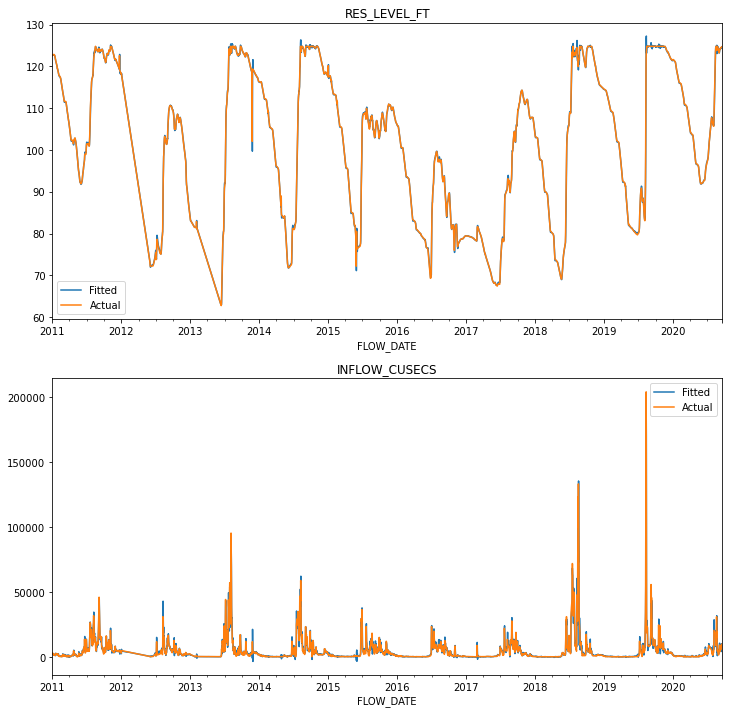

In [204]:
fig, ax = plt.subplots(nrows=endo_train.shape[1], ncols=1, figsize=(12, 12))

for i, column in enumerate(endo_train.columns):
    model_fitted.fittedvalues[column].plot(ax=ax[i], label='Fitted', title=column)
    endo_train[column].plot(ax=ax[i], label='Actual', title=column)
    ax[i].legend()

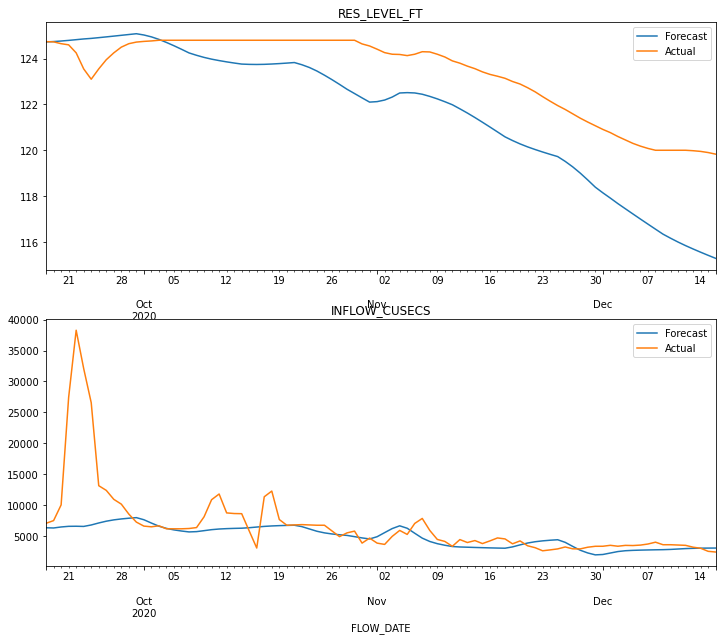

In [205]:
fig, ax = plt.subplots(nrows=forecast_df.shape[1], ncols=1, figsize=(12, 10))

for i, column in enumerate(forecast_df.columns):
    forecast_df[column].plot(ax=ax[i], label='Forecast', title=column)
    endo_test[column].plot(ax=ax[i], label='Actual', title=column)
    ax[i].legend()

### Model 7

Endogenous Variables:
* 'RES_LEVEL_FT'
* 'OUTFLOW_CUECS'

Exogenous Variables

* WEEK_NO
* MONTH_NO

Optimization:
* AIC

In [206]:
dummy_data = dataset.copy()
dummy_data['WEEK_NO'] = dummy_data['WEEK_NO'].astype(int).astype(str)
dummy_data['MONTH_NO'] = dummy_data['MONTH_NO'].astype(int).astype(str)
dummy_data = pd.get_dummies(dummy_data)

In [207]:
time_col = 'FLOW_DATE'
internal_regressors = ['RES_LEVEL_FT', 'OUTFLOW_CUECS']
initial = 3000
steps = 50
horizon = 90
selection_type = 'aic'
max_lag = 50

In [208]:
external_regressors = [column for column in dummy_data.columns if column not in ['FLOW_DATE', 'INFLOW_CUSECS', 'OUTFLOW_CUECS', 'RES_LEVEL_FT']]

In [209]:
cv_results = cross_validate(dummy_data,
               time_col,
               internal_regressors,
               initial,
               steps,
               horizon,
               external_regressors,
               scoring_function=mean_absolute_percentage_error,
               max_lag=50,
               selection_type=selection_type)

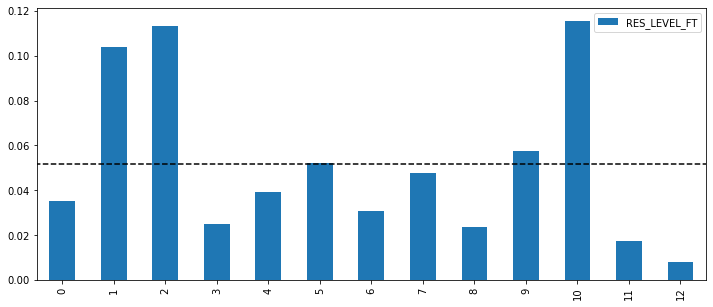

In [210]:
fig, ax = plt.subplots(figsize=(12, 5))
cv_results[['RES_LEVEL_FT']].plot.bar(ax=ax)
average_error = cv_results['RES_LEVEL_FT'].mean()
ax.plot([-1, cv_results.shape[0]], [average_error, average_error], "k--")

In [211]:
endo_train, exo_train, endo_test, exo_test = split_dataset(dummy_data, 
              time_col, 
              '2011-01-01',
              '2020-09-18',
              '2020-12-16',
              internal_regressors, 
              external_regressors=external_regressors)

model_fitted, lag_selection, optimal_lag = fit_model(endo_train, exo_train=exo_train, maxlag=max_lag, selection_type=selection_type)

forecast_df = forecast_model(model_fitted, endo_train, endo_test, exo_test=exo_test, optimal_lag=optimal_lag, forecast_horizon=horizon)

print(evaluate_fit(forecast_df, endo_test, mean_absolute_percentage_error))

   RES_LEVEL_FT  OUTFLOW_CUECS
0       0.01563       0.272951


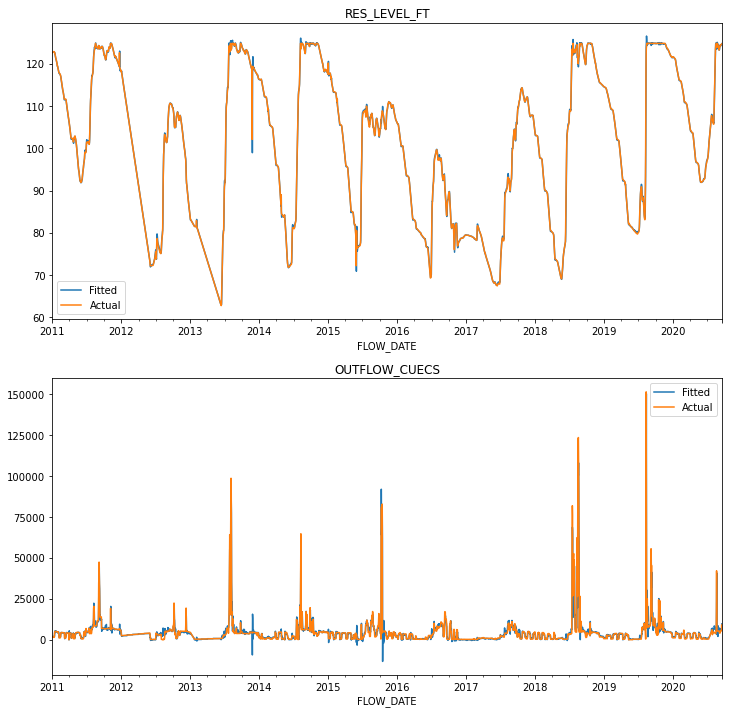

In [212]:
fig, ax = plt.subplots(nrows=endo_train.shape[1], ncols=1, figsize=(12, 12))

for i, column in enumerate(endo_train.columns):
    model_fitted.fittedvalues[column].plot(ax=ax[i], label='Fitted', title=column)
    endo_train[column].plot(ax=ax[i], label='Actual', title=column)
    ax[i].legend()

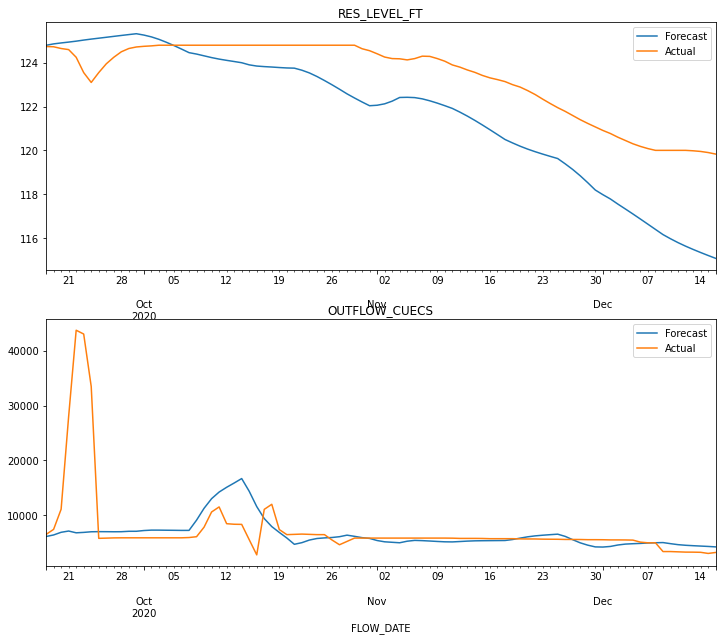

In [213]:
fig, ax = plt.subplots(nrows=forecast_df.shape[1], ncols=1, figsize=(12, 10))

for i, column in enumerate(forecast_df.columns):
    forecast_df[column].plot(ax=ax[i], label='Forecast', title=column)
    endo_test[column].plot(ax=ax[i], label='Actual', title=column)
    ax[i].legend()

### Model 8

Endogenous Variables:
* 'RES_LEVEL_FT'
* 'OUTFLOW_CUECS'

Exogenous Variables

* WEEK_NO
* MONTH_NO

Optimization:
* BIC

In [214]:
dummy_data = dataset.copy()
dummy_data['WEEK_NO'] = dummy_data['WEEK_NO'].astype(int).astype(str)
dummy_data['MONTH_NO'] = dummy_data['MONTH_NO'].astype(int).astype(str)
dummy_data = pd.get_dummies(dummy_data)

In [215]:
time_col = 'FLOW_DATE'
internal_regressors = ['RES_LEVEL_FT', 'OUTFLOW_CUECS']
initial = 3000
steps = 50
horizon = 90
selection_type = 'bic'
max_lag = 50

In [216]:
external_regressors = [column for column in dummy_data.columns if column not in ['FLOW_DATE', 'INFLOW_CUSECS', 'OUTFLOW_CUECS', 'RES_LEVEL_FT']]

In [217]:
cv_results = cross_validate(dummy_data,
               time_col,
               internal_regressors,
               initial,
               steps,
               horizon,
               external_regressors,
               scoring_function=mean_absolute_percentage_error,
               max_lag=50,
               selection_type=selection_type)

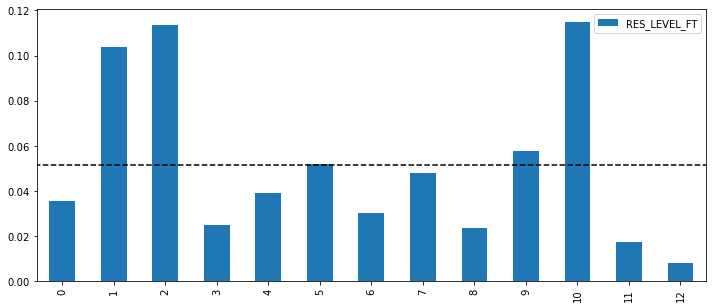

In [218]:
fig, ax = plt.subplots(figsize=(12, 5))
cv_results[['RES_LEVEL_FT']].plot.bar(ax=ax)
average_error = cv_results['RES_LEVEL_FT'].mean()
ax.plot([-1, cv_results.shape[0]], [average_error, average_error], "k--")

In [219]:
endo_train, exo_train, endo_test, exo_test = split_dataset(dummy_data, 
              time_col, 
              '2011-01-01',
              '2020-09-18',
              '2020-12-16',
              internal_regressors, 
              external_regressors=external_regressors)

model_fitted, lag_selection, optimal_lag = fit_model(endo_train, exo_train=exo_train, maxlag=max_lag, selection_type=selection_type)

forecast_df = forecast_model(model_fitted, endo_train, endo_test, exo_test=exo_test, optimal_lag=optimal_lag, forecast_horizon=horizon)

print(evaluate_fit(forecast_df, endo_test, mean_absolute_percentage_error))

   RES_LEVEL_FT  OUTFLOW_CUECS
0      0.015529       0.269272


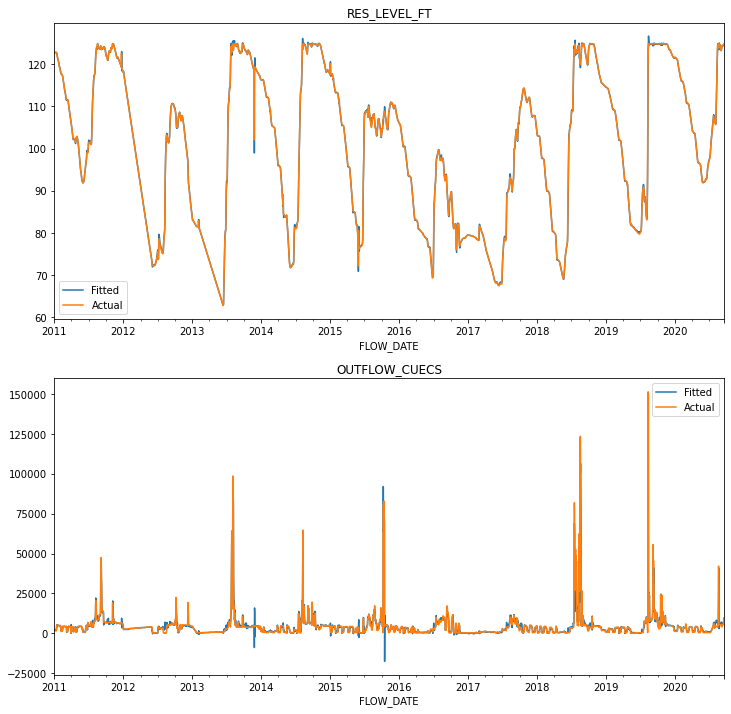

In [220]:
fig, ax = plt.subplots(nrows=endo_train.shape[1], ncols=1, figsize=(12, 12))

for i, column in enumerate(endo_train.columns):
    model_fitted.fittedvalues[column].plot(ax=ax[i], label='Fitted', title=column)
    endo_train[column].plot(ax=ax[i], label='Actual', title=column)
    ax[i].legend()

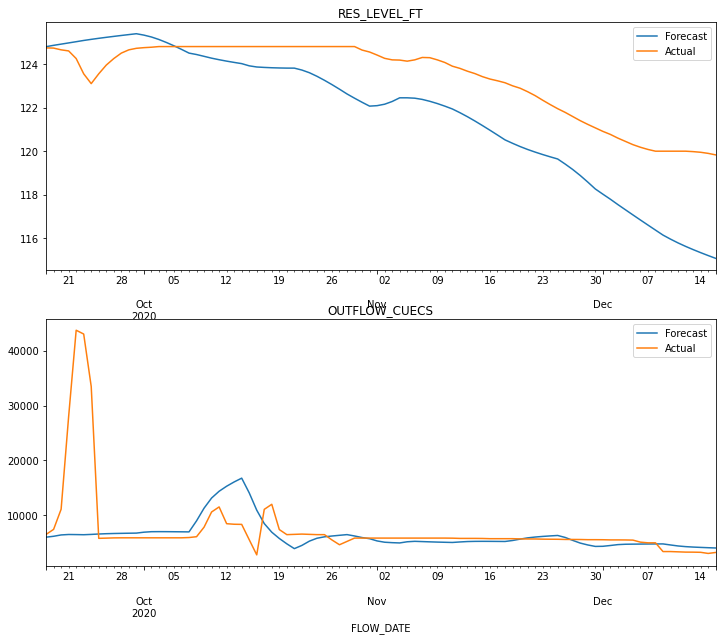

In [221]:
fig, ax = plt.subplots(nrows=forecast_df.shape[1], ncols=1, figsize=(12, 10))

for i, column in enumerate(forecast_df.columns):
    forecast_df[column].plot(ax=ax[i], label='Forecast', title=column)
    endo_test[column].plot(ax=ax[i], label='Actual', title=column)
    ax[i].legend()

## Model 9

Endogenous Variables:
* RES_LEVEL_FT
* INFLOW_CUSECS
* OUTFLOW_CUECS

Exogenous Variables

* WEEK_NO
* MONTH_NO

Optimization:
* AIC

In [222]:
dummy_data = dataset.copy()
dummy_data['WEEK_NO'] = dummy_data['WEEK_NO'].astype(int).astype(str)
dummy_data['MONTH_NO'] = dummy_data['MONTH_NO'].astype(int).astype(str)
dummy_data = pd.get_dummies(dummy_data)

In [223]:
time_col = 'FLOW_DATE'
internal_regressors = ['RES_LEVEL_FT', 'INFLOW_CUSECS', 'OUTFLOW_CUECS']
initial = 3000
steps = 50
horizon = 90
selection_type = 'aic'
max_lag = 50

In [224]:
external_regressors = [column for column in dummy_data.columns if column not in ['FLOW_DATE', 'INFLOW_CUSECS', 'OUTFLOW_CUECS', 'RES_LEVEL_FT']]

In [225]:
cv_results = cross_validate(dummy_data,
               time_col,
               internal_regressors,
               initial,
               steps,
               horizon,
               external_regressors,
               scoring_function=mean_absolute_percentage_error,
               max_lag=50,
               selection_type=selection_type)

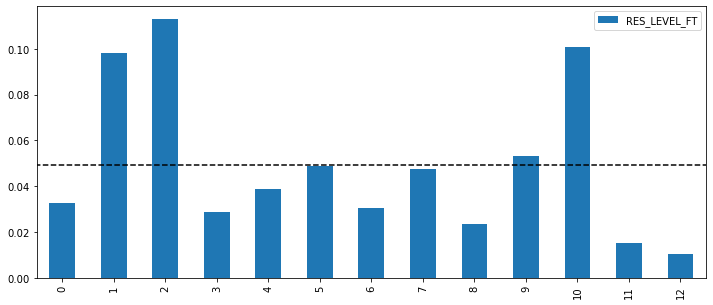

In [226]:
fig, ax = plt.subplots(figsize=(12, 5))
cv_results[['RES_LEVEL_FT']].plot.bar(ax=ax)
average_error = cv_results['RES_LEVEL_FT'].mean()
ax.plot([-1, cv_results.shape[0]], [average_error, average_error], "k--")

In [227]:
endo_train, exo_train, endo_test, exo_test = split_dataset(dummy_data, 
              time_col, 
              '2011-01-01',
              '2020-09-18',
              '2020-12-16',
              internal_regressors, 
              external_regressors=external_regressors)

model_fitted, lag_selection, optimal_lag = fit_model(endo_train, exo_train=exo_train, maxlag=max_lag, selection_type=selection_type)

forecast_df = forecast_model(model_fitted, endo_train, endo_test, exo_test=exo_test, optimal_lag=optimal_lag, forecast_horizon=horizon)

print(evaluate_fit(forecast_df, endo_test, mean_absolute_percentage_error))

   RES_LEVEL_FT  INFLOW_CUSECS  OUTFLOW_CUECS
0      0.014241       0.236055       0.267255


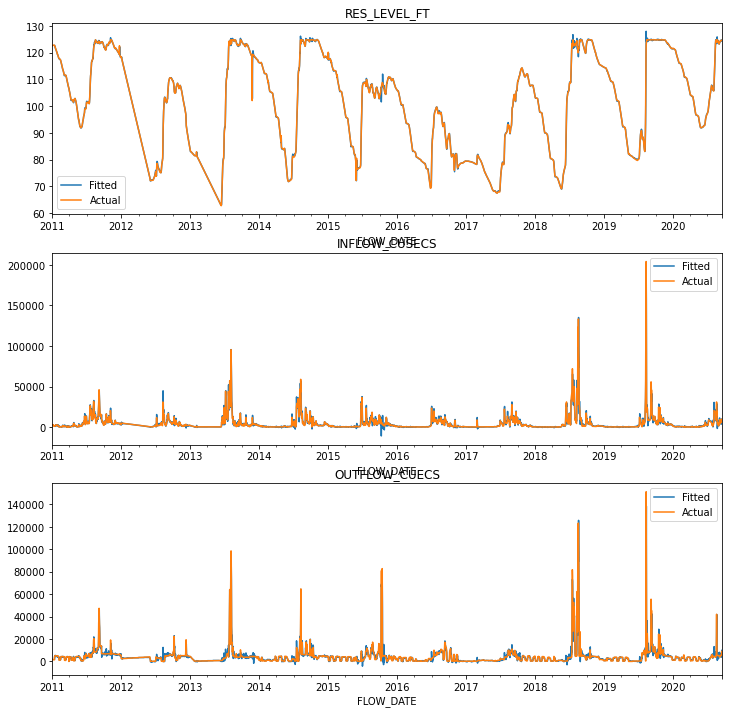

In [228]:
fig, ax = plt.subplots(nrows=endo_train.shape[1], ncols=1, figsize=(12, 12))

for i, column in enumerate(endo_train.columns):
    model_fitted.fittedvalues[column].plot(ax=ax[i], label='Fitted', title=column)
    endo_train[column].plot(ax=ax[i], label='Actual', title=column)
    ax[i].legend()

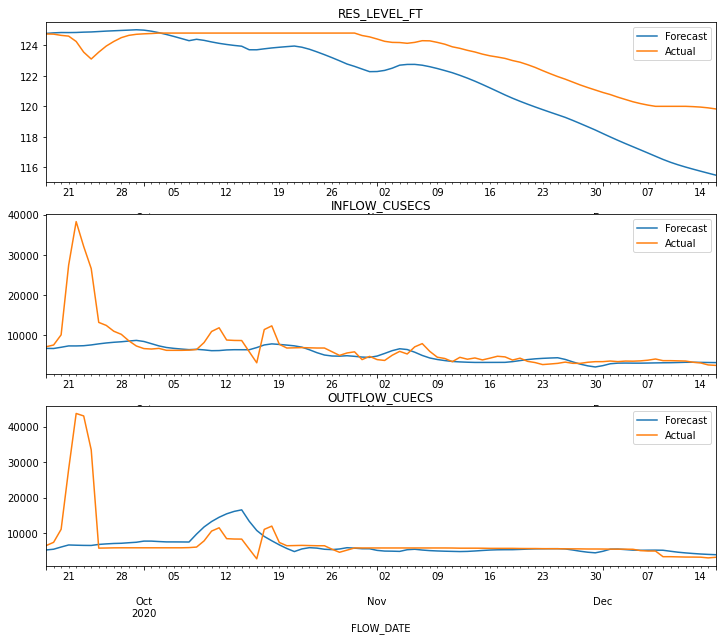

In [229]:
fig, ax = plt.subplots(nrows=forecast_df.shape[1], ncols=1, figsize=(12, 10))

for i, column in enumerate(forecast_df.columns):
    forecast_df[column].plot(ax=ax[i], label='Forecast', title=column)
    endo_test[column].plot(ax=ax[i], label='Actual', title=column)
    ax[i].legend()

## Model 10

Endogenous Variables:
* RES_LEVEL_FT
* INFLOW_CUSECS
* OUTFLOW_CUECS

Exogenous Variables

* WEEK_NO
* MONTH_NO

Optimization:
* BIC

In [230]:
dummy_data = dataset.copy()
dummy_data['WEEK_NO'] = dummy_data['WEEK_NO'].astype(int).astype(str)
dummy_data['MONTH_NO'] = dummy_data['MONTH_NO'].astype(int).astype(str)
dummy_data = pd.get_dummies(dummy_data)

In [231]:
time_col = 'FLOW_DATE'
internal_regressors = ['RES_LEVEL_FT', 'INFLOW_CUSECS', 'OUTFLOW_CUECS']
initial = 3000
steps = 50
horizon = 90
selection_type = 'bic'
max_lag = 50

In [232]:
external_regressors = [column for column in dummy_data.columns if column not in ['FLOW_DATE', 'INFLOW_CUSECS', 'OUTFLOW_CUECS', 'RES_LEVEL_FT']]

In [233]:
cv_results = cross_validate(dummy_data,
               time_col,
               internal_regressors,
               initial,
               steps,
               horizon,
               external_regressors,
               scoring_function=mean_absolute_percentage_error,
               max_lag=50,
               selection_type=selection_type)

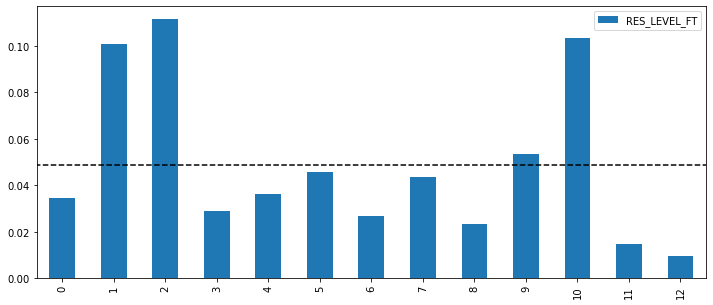

In [234]:
fig, ax = plt.subplots(figsize=(12, 5))
cv_results[['RES_LEVEL_FT']].plot.bar(ax=ax)
average_error = cv_results['RES_LEVEL_FT'].mean()
ax.plot([-1, cv_results.shape[0]], [average_error, average_error], "k--")

In [235]:
endo_train, exo_train, endo_test, exo_test = split_dataset(dummy_data, 
              time_col, 
              '2011-01-01',
              '2020-09-18',
              '2020-12-16',
              internal_regressors, 
              external_regressors=external_regressors)

model_fitted, lag_selection, optimal_lag = fit_model(endo_train, exo_train=exo_train, maxlag=max_lag, selection_type=selection_type)

forecast_df = forecast_model(model_fitted, endo_train, endo_test, exo_test=exo_test, optimal_lag=optimal_lag, forecast_horizon=horizon)

print(evaluate_fit(forecast_df, endo_test, mean_absolute_percentage_error))

   RES_LEVEL_FT  INFLOW_CUSECS  OUTFLOW_CUECS
0      0.013668       0.239456        0.25899


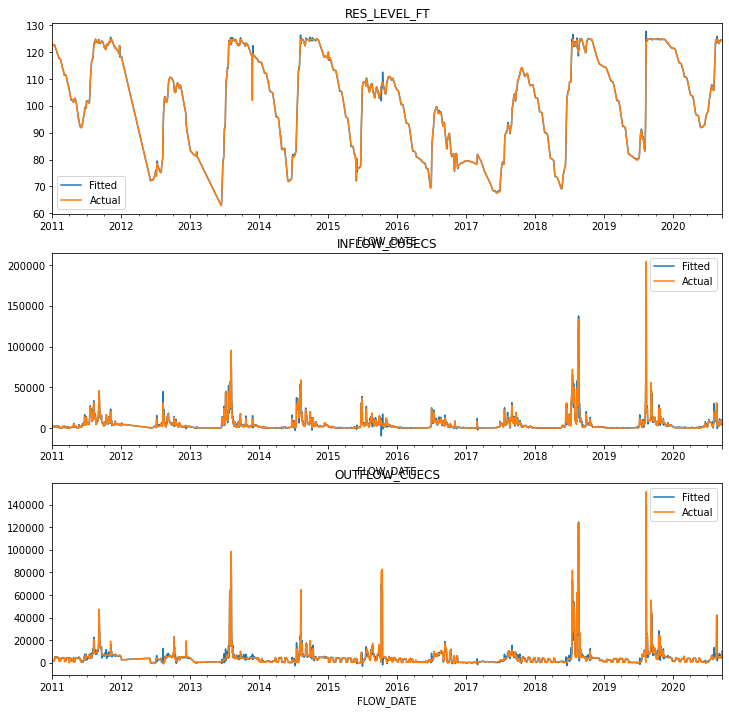

In [236]:
fig, ax = plt.subplots(nrows=endo_train.shape[1], ncols=1, figsize=(12, 12))

for i, column in enumerate(endo_train.columns):
    model_fitted.fittedvalues[column].plot(ax=ax[i], label='Fitted', title=column)
    endo_train[column].plot(ax=ax[i], label='Actual', title=column)
    ax[i].legend()

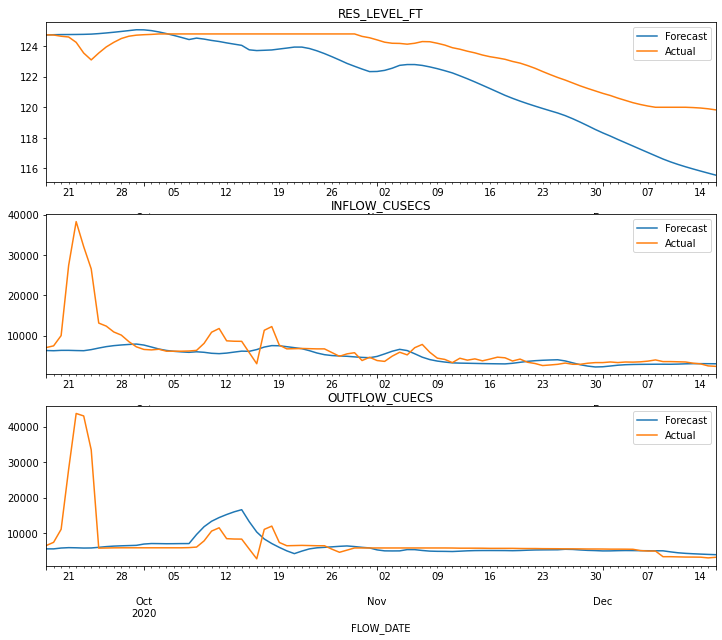

In [237]:
fig, ax = plt.subplots(nrows=forecast_df.shape[1], ncols=1, figsize=(12, 10))

for i, column in enumerate(forecast_df.columns):
    forecast_df[column].plot(ax=ax[i], label='Forecast', title=column)
    endo_test[column].plot(ax=ax[i], label='Actual', title=column)
    ax[i].legend()

# Model 11

Endogenous Variables:
* Diff(RES_LEVEL_FT)
* INFLOW_CUSECS - OUTFLOW_CUECS

Exogenous Variables:
* WEEK_NO
* MONTH_NO

Optimization:
* AIC

In [238]:
dummy_data = dataset.copy()
diff_seed = dummy_data['RES_LEVEL_FT'].values[0]
dummy_data['RES_LEVEL_FT'] = dummy_data['RES_LEVEL_FT'].diff()
dummy_data = dummy_data.dropna()
dummy_data['FLOW_DIFF'] = dummy_data['INFLOW_CUSECS'] - dummy_data['OUTFLOW_CUECS']
dummy_data = dummy_data.drop(columns=['INFLOW_CUSECS', 'OUTFLOW_CUECS'])
dummy_data['WEEK_NO'] = dummy_data['WEEK_NO'].astype(int).astype(str)
dummy_data['MONTH_NO'] = dummy_data['MONTH_NO'].astype(int).astype(str)
dummy_data = pd.get_dummies(dummy_data)

In [239]:
time_col = 'FLOW_DATE'
internal_regressors = ['RES_LEVEL_FT', 'FLOW_DIFF']
initial = 3000
steps = 50
horizon = 90
selection_type = 'aic'
max_lag = 50
scoring_function = mean_absolute_percentage_error

In [240]:
external_regressors = [column for column in dummy_data.columns if column not in ['FLOW_DATE', 'FLOW_DIFF', 'RES_LEVEL_FT']]

In [241]:
cv_results = cross_validate(dummy_data,
                            time_col,
                            internal_regressors,
                            initial,
                            steps,
                            horizon,
                            external_regressors,
                            scoring_function=mean_absolute_percentage_error,
                            max_lag=50,
                            selection_type=selection_type, 
                            diff_seed=diff_seed)

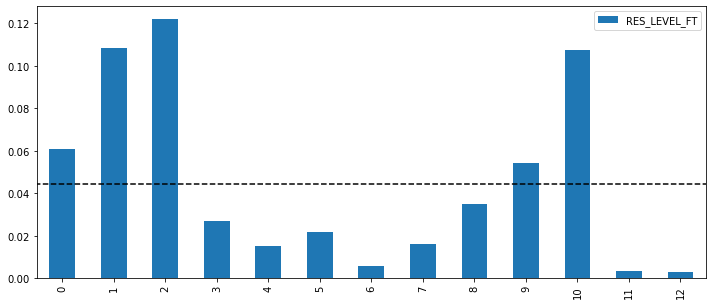

In [242]:
fig, ax = plt.subplots(figsize=(12, 5))
cv_results[['RES_LEVEL_FT']].plot.bar(ax=ax)
average_error = cv_results['RES_LEVEL_FT'].mean()
ax.plot([-1, cv_results.shape[0]], [average_error, average_error], "k--")

In [243]:
endo_train, exo_train, endo_test, exo_test = split_dataset(dummy_data, 
              time_col, 
              '2011-01-01',
              '2020-09-18',
              '2020-12-16',
              internal_regressors, 
              external_regressors=external_regressors)

model_fitted, lag_selection, optimal_lag = fit_model(endo_train, exo_train=exo_train, maxlag=max_lag, selection_type=selection_type)

forecast_df = forecast_model(model_fitted, endo_train, endo_test, exo_test=exo_test, optimal_lag=optimal_lag, forecast_horizon=horizon)

In [244]:
endo_train.iloc[0, 0] = endo_train.iloc[0, 0] + diff_seed
endo_train['RES_LEVEL_FT'] = endo_train['RES_LEVEL_FT'].cumsum()

In [245]:
endo_test.iloc[0, 0] = endo_test.iloc[0, 0] + endo_train.iloc[-1, 0]
endo_test['RES_LEVEL_FT'] = endo_test['RES_LEVEL_FT'].cumsum()

In [246]:
forecast_df.iloc[0, 0] = forecast_df.iloc[0, 0] + endo_train.iloc[-1, 0]
forecast_df['RES_LEVEL_FT'] = forecast_df['RES_LEVEL_FT'].cumsum()

In [247]:
print(evaluate_fit(forecast_df, endo_test, mean_absolute_percentage_error))

   RES_LEVEL_FT  FLOW_DIFF
0       0.00726   5.326268


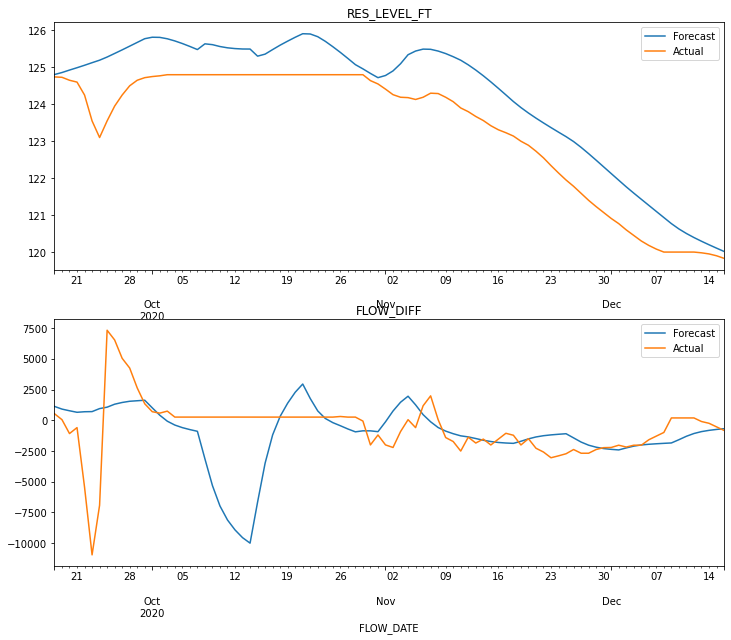

In [248]:
fig, ax = plt.subplots(nrows=forecast_df.shape[1], ncols=1, figsize=(12, 10))

for i, column in enumerate(forecast_df.columns):
    forecast_df[column].plot(ax=ax[i], label='Forecast', title=column)
    endo_test[column].plot(ax=ax[i], label='Actual', title=column)
    ax[i].legend()

# Model 12

Endogenous Variables:
* Diff(RES_LEVEL_FT)
* INFLOW_CUSECS - OUTFLOW_CUECS

Exogenous Variables:
* WEEK_NO
* MONTH_NO

Optimization:
* BIC

In [249]:
dummy_data = dataset.copy()
diff_seed = dummy_data['RES_LEVEL_FT'].values[0]
dummy_data['RES_LEVEL_FT'] = dummy_data['RES_LEVEL_FT'].diff()
dummy_data = dummy_data.dropna()
dummy_data['FLOW_DIFF'] = dummy_data['INFLOW_CUSECS'] - dummy_data['OUTFLOW_CUECS']
dummy_data = dummy_data.drop(columns=['INFLOW_CUSECS', 'OUTFLOW_CUECS'])
dummy_data['WEEK_NO'] = dummy_data['WEEK_NO'].astype(int).astype(str)
dummy_data['MONTH_NO'] = dummy_data['MONTH_NO'].astype(int).astype(str)
dummy_data = pd.get_dummies(dummy_data)

In [250]:
time_col = 'FLOW_DATE'
internal_regressors = ['RES_LEVEL_FT', 'FLOW_DIFF']
initial = 3000
steps = 50
horizon = 90
selection_type = 'bic'
max_lag = 50
scoring_function = mean_absolute_percentage_error

In [251]:
external_regressors = [column for column in dummy_data.columns if column not in ['FLOW_DATE', 'FLOW_DIFF', 'RES_LEVEL_FT']]

In [252]:
cv_results = cross_validate(dummy_data,
                            time_col,
                            internal_regressors,
                            initial,
                            steps,
                            horizon,
                            external_regressors,
                            scoring_function=mean_absolute_percentage_error,
                            max_lag=50,
                            selection_type=selection_type, 
                            diff_seed=diff_seed)

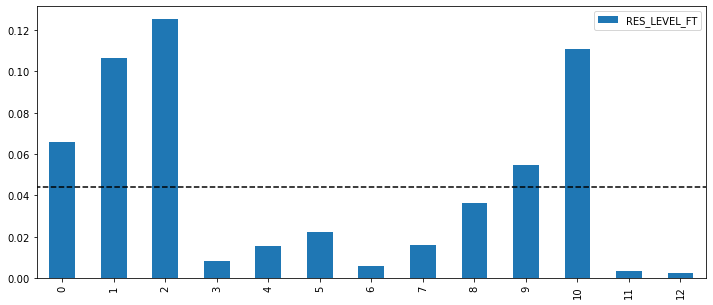

In [253]:
fig, ax = plt.subplots(figsize=(12, 5))
cv_results[['RES_LEVEL_FT']].plot.bar(ax=ax)
average_error = cv_results['RES_LEVEL_FT'].mean()
ax.plot([-1, cv_results.shape[0]], [average_error, average_error], "k--")

In [254]:
endo_train, exo_train, endo_test, exo_test = split_dataset(dummy_data, 
              time_col, 
              '2011-01-01',
              '2020-09-18',
              '2020-12-16',
              internal_regressors, 
              external_regressors=external_regressors)

model_fitted, lag_selection, optimal_lag = fit_model(endo_train, exo_train=exo_train, maxlag=max_lag, selection_type=selection_type)

forecast_df = forecast_model(model_fitted, endo_train, endo_test, exo_test=exo_test, optimal_lag=optimal_lag, forecast_horizon=horizon)

In [255]:
endo_train.iloc[0, 0] = endo_train.iloc[0, 0] + diff_seed
endo_train['RES_LEVEL_FT'] = endo_train['RES_LEVEL_FT'].cumsum()

In [256]:
endo_test.iloc[0, 0] = endo_test.iloc[0, 0] + endo_train.iloc[-1, 0]
endo_test['RES_LEVEL_FT'] = endo_test['RES_LEVEL_FT'].cumsum()

In [257]:
forecast_df.iloc[0, 0] = forecast_df.iloc[0, 0] + endo_train.iloc[-1, 0]
forecast_df['RES_LEVEL_FT'] = forecast_df['RES_LEVEL_FT'].cumsum()

In [258]:
print(evaluate_fit(forecast_df, endo_test, mean_absolute_percentage_error))

   RES_LEVEL_FT  FLOW_DIFF
0      0.007261   5.457891


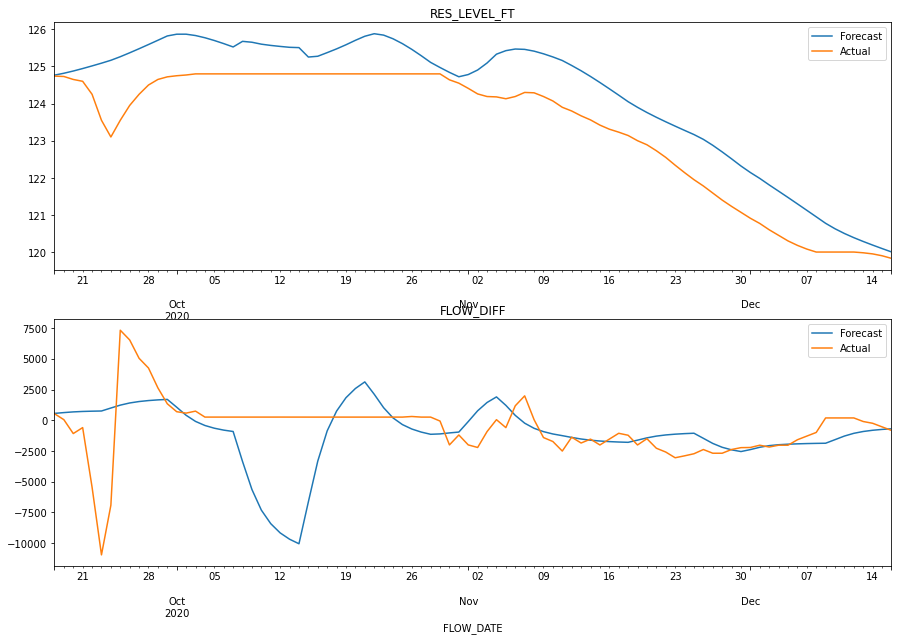

In [259]:
fig, ax = plt.subplots(nrows=forecast_df.shape[1], ncols=1, figsize=(15, 10))

for i, column in enumerate(forecast_df.columns):
    forecast_df[column].plot(ax=ax[i], label='Forecast', title=column)
    endo_test[column].plot(ax=ax[i], label='Actual', title=column)
    ax[i].legend()

# Model 13

Endogenous Variables:
* Diff(RES_LEVEL_FT)
* Diff(RES_LEVEL_FT) ^ 2
* Diff(RES_LEVEL_FT) ^ 3
* Diff(RES_LEVEL_FT) ^ 4
* INFLOW_CUSECS - OUTFLOW_CUECS

Exogenous Variables:
* WEEK_NO
* MONTH_NO

Optimization:
* BIC

In [260]:
dummy_data = dataset.copy()
diff_seed = dummy_data['RES_LEVEL_FT'].values[0]
dummy_data['RES_LEVEL_FT'] = dummy_data['RES_LEVEL_FT'].diff()
dummy_data['RES_LEVEL_FT_2'] = np.square(dummy_data['RES_LEVEL_FT'])
dummy_data['RES_LEVEL_FT_3'] = np.power(dummy_data['RES_LEVEL_FT'], 3)
dummy_data['RES_LEVEL_FT_4'] = np.power(dummy_data['RES_LEVEL_FT'], 4)
dummy_data = dummy_data.dropna()
dummy_data['FLOW_DIFF'] = dummy_data['INFLOW_CUSECS'] - dummy_data['OUTFLOW_CUECS']
dummy_data = dummy_data.drop(columns=['INFLOW_CUSECS', 'OUTFLOW_CUECS'])
dummy_data['WEEK_NO'] = dummy_data['WEEK_NO'].astype(int).astype(str)
dummy_data['MONTH_NO'] = dummy_data['MONTH_NO'].astype(int).astype(str)
dummy_data = pd.get_dummies(dummy_data)

In [261]:
time_col = 'FLOW_DATE'
internal_regressors = ['RES_LEVEL_FT', 'FLOW_DIFF', 'RES_LEVEL_FT_2', 'RES_LEVEL_FT_3', 'RES_LEVEL_FT_4']
initial = 3000
steps = 50
horizon = 90
selection_type = 'bic'
max_lag = 50
scoring_function = mean_absolute_percentage_error

In [262]:
external_regressors = [column for column in dummy_data.columns if column not in ['FLOW_DATE'] + internal_regressors]

In [263]:
cv_results = cross_validate(dummy_data,
                            time_col,
                            internal_regressors,
                            initial,
                            steps,
                            horizon,
                            external_regressors,
                            scoring_function=mean_absolute_percentage_error,
                            max_lag=50,
                            selection_type=selection_type, 
                            diff_seed=diff_seed)

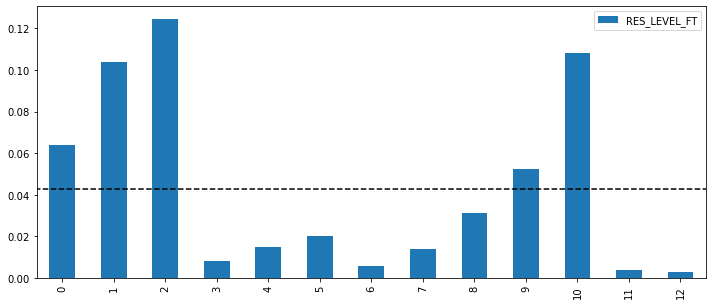

In [264]:
fig, ax = plt.subplots(figsize=(12, 5))
cv_results[['RES_LEVEL_FT']].plot.bar(ax=ax)
average_error = cv_results['RES_LEVEL_FT'].mean()
ax.plot([-1, cv_results.shape[0]], [average_error, average_error], "k--")

In [265]:
endo_train, exo_train, endo_test, exo_test = split_dataset(dummy_data, 
              time_col, 
              '2011-01-01',
              '2020-09-18',
              '2020-12-16',
              internal_regressors, 
              external_regressors=external_regressors)

model_fitted, lag_selection, optimal_lag = fit_model(endo_train, exo_train=exo_train, maxlag=max_lag, selection_type=selection_type)

forecast_df = forecast_model(model_fitted, endo_train, endo_test, exo_test=exo_test, optimal_lag=optimal_lag, forecast_horizon=horizon)

In [266]:
endo_train.iloc[0, 0] = endo_train.iloc[0, 0] + diff_seed
endo_train['RES_LEVEL_FT'] = endo_train['RES_LEVEL_FT'].cumsum()

In [267]:
endo_test.iloc[0, 0] = endo_test.iloc[0, 0] + endo_train.iloc[-1, 0]
endo_test['RES_LEVEL_FT'] = endo_test['RES_LEVEL_FT'].cumsum()

In [268]:
forecast_df.iloc[0, 0] = forecast_df.iloc[0, 0] + endo_train.iloc[-1, 0]
forecast_df['RES_LEVEL_FT'] = forecast_df['RES_LEVEL_FT'].cumsum()

In [269]:
print(evaluate_fit(forecast_df, endo_test, mean_absolute_percentage_error))

   RES_LEVEL_FT  FLOW_DIFF  RES_LEVEL_FT_2  RES_LEVEL_FT_3  RES_LEVEL_FT_4
0      0.009582   5.453828    1.698437e+14    1.257058e+15    1.071064e+16


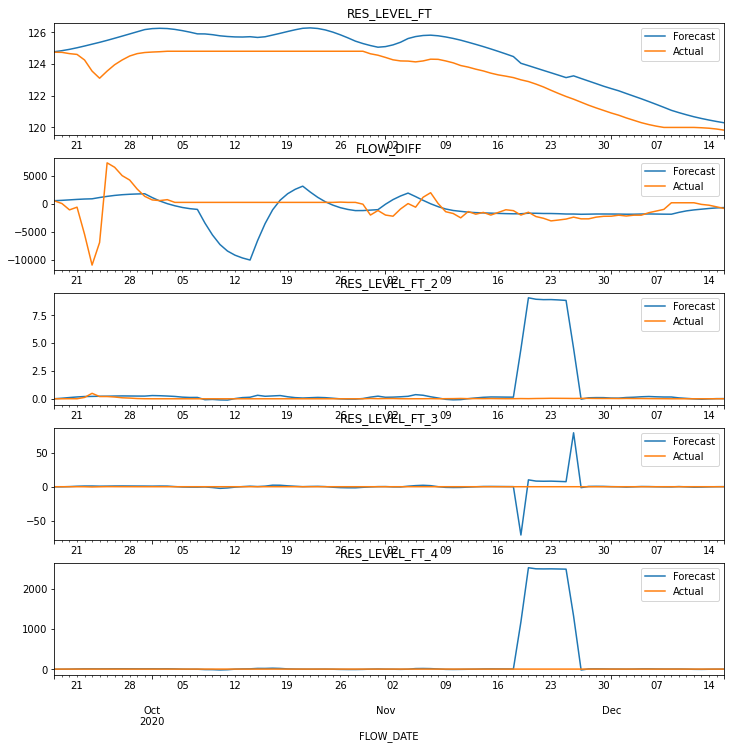

In [270]:
fig, ax = plt.subplots(nrows=forecast_df.shape[1], ncols=1, figsize=(12, 12))

for i, column in enumerate(forecast_df.columns):
    forecast_df[column].plot(ax=ax[i], label='Forecast', title=column)
    endo_test[column].plot(ax=ax[i], label='Actual', title=column)
    ax[i].legend()

# Model 14

Endogenous Variables:
* Diff(RES_LEVEL_FT)
* Diff(RES_LEVEL_FT) ^ 2
* Diff(RES_LEVEL_FT) ^ 3
* Diff(RES_LEVEL_FT) ^ 4
* INFLOW_CUSECS
* OUTFLOW_CUECS

Exogenous Variables:
* WEEK_NO
* MONTH_NO

Optimization:
* BIC

In [271]:
dummy_data = dataset.copy()
diff_seed = dummy_data['RES_LEVEL_FT'].values[0]
dummy_data['RES_LEVEL_FT'] = dummy_data['RES_LEVEL_FT'].diff()
dummy_data['RES_LEVEL_FT_2'] = np.square(dummy_data['RES_LEVEL_FT'])
dummy_data['RES_LEVEL_FT_3'] = np.power(dummy_data['RES_LEVEL_FT'], 3)
dummy_data['RES_LEVEL_FT_4'] = np.power(dummy_data['RES_LEVEL_FT'], 4)
dummy_data = dummy_data.dropna()
dummy_data['WEEK_NO'] = dummy_data['WEEK_NO'].astype(int).astype(str)
dummy_data['MONTH_NO'] = dummy_data['MONTH_NO'].astype(int).astype(str)
dummy_data = pd.get_dummies(dummy_data)

In [272]:
time_col = 'FLOW_DATE'
internal_regressors = ['RES_LEVEL_FT', 'INFLOW_CUSECS', 'OUTFLOW_CUECS', 'RES_LEVEL_FT_2', 'RES_LEVEL_FT_3', 'RES_LEVEL_FT_4']
initial = 3000
steps = 50
horizon = 90
selection_type = 'bic'
max_lag = 50
scoring_function = mean_absolute_percentage_error

In [273]:
external_regressors = [column for column in dummy_data.columns if column not in ['FLOW_DATE'] + internal_regressors]

In [274]:
cv_results = cross_validate(dummy_data,
                            time_col,
                            internal_regressors,
                            initial,
                            steps,
                            horizon,
                            external_regressors,
                            scoring_function=mean_absolute_percentage_error,
                            max_lag=50,
                            selection_type=selection_type, 
                            diff_seed=diff_seed)

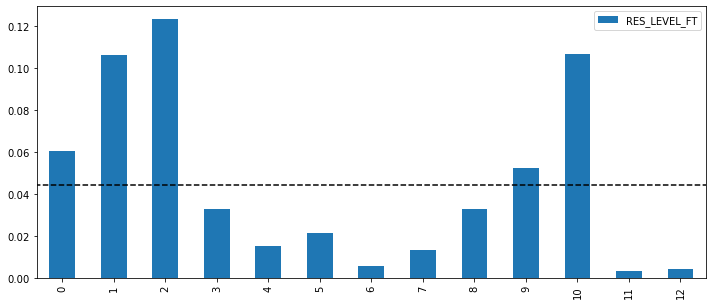

In [275]:
fig, ax = plt.subplots(figsize=(12, 5))
cv_results[['RES_LEVEL_FT']].plot.bar(ax=ax)
average_error = cv_results['RES_LEVEL_FT'].mean()
ax.plot([-1, cv_results.shape[0]], [average_error, average_error], "k--")

In [276]:
endo_train, exo_train, endo_test, exo_test = split_dataset(dummy_data, 
              time_col, 
              '2011-01-01',
              '2020-09-18',
              '2020-12-16',
              internal_regressors, 
              external_regressors=external_regressors)

model_fitted, lag_selection, optimal_lag = fit_model(endo_train, exo_train=exo_train, maxlag=max_lag, selection_type=selection_type)

forecast_df = forecast_model(model_fitted, endo_train, endo_test, exo_test=exo_test, optimal_lag=optimal_lag, forecast_horizon=horizon)

In [277]:
endo_train.iloc[0, 0] = endo_train.iloc[0, 0] + diff_seed
endo_train['RES_LEVEL_FT'] = endo_train['RES_LEVEL_FT'].cumsum()

In [278]:
endo_test.iloc[0, 0] = endo_test.iloc[0, 0] + endo_train.iloc[-1, 0]
endo_test['RES_LEVEL_FT'] = endo_test['RES_LEVEL_FT'].cumsum()

In [279]:
forecast_df.iloc[0, 0] = forecast_df.iloc[0, 0] + endo_train.iloc[-1, 0]
forecast_df['RES_LEVEL_FT'] = forecast_df['RES_LEVEL_FT'].cumsum()

In [280]:
print(evaluate_fit(forecast_df, endo_test, mean_absolute_percentage_error))

   RES_LEVEL_FT  INFLOW_CUSECS  OUTFLOW_CUECS  RES_LEVEL_FT_2  RES_LEVEL_FT_3  \
0      0.008319       0.291801       0.305583    1.733300e+14    9.593508e+14   

   RES_LEVEL_FT_4  
0    1.019343e+16  


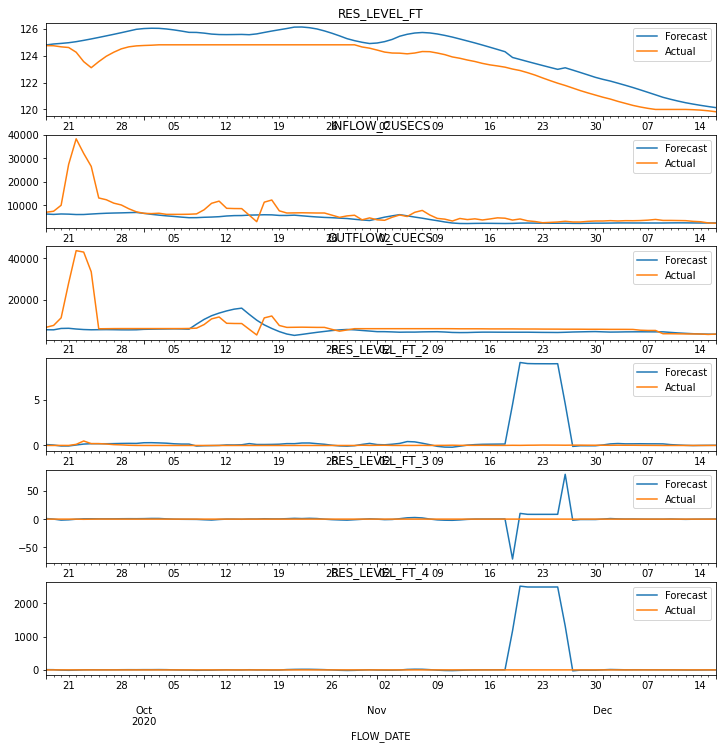

In [281]:
fig, ax = plt.subplots(nrows=forecast_df.shape[1], ncols=1, figsize=(12, 12))

for i, column in enumerate(forecast_df.columns):
    forecast_df[column].plot(ax=ax[i], label='Forecast', title=column)
    endo_test[column].plot(ax=ax[i], label='Actual', title=column)
    ax[i].legend()